<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Sound classification



# Plan of attack
<hr style = "border:2px solid black" ></hr>


- We will start with sound files, convert them into spectrograms, input them into a CNN plus linear classifier model and produce predictions about the class to which the sounds belongs.

- A **linear classifier** is based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a **feature vector**.
    


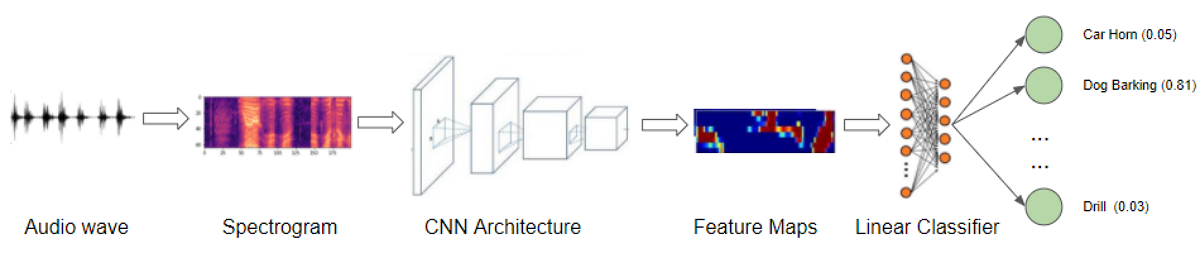

# Import modules
<hr style = "border:2px solid black" ></hr>

In [ ]:
import pandas as pd
from pathlib import Path
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.nn import init

# Import dataset
<hr style = "border:2px solid black" ></hr>


- For our demo, we will use the Urban Sound 8K dataset that consists of a corpus of ordinary sounds recorded from day-to-day city life. 
- The sounds are taken from 10 classes such as drilling, dogs barking, and sirens.
- The adataset, we see that it consists of two parts:

    - Audio files in the ‘audio’ folder: It has 10 sub-folders named ‘fold1’ through ‘fold10’. Each sub-folder contains a number of ‘.wav’ audio samples eg. ‘fold1/103074–7–1–0.wav’
    - Metadata in the ‘metadata’ folder: It has a file ‘UrbanSound8K.csv’ that contains information about each audio sample in the dataset such as its filename, its class label, the ‘fold’ sub-folder location, and so on. The class label is a numeric Class ID from 0–9 for each of the 10 classes. eg. the number 0 means air conditioner, 1 is a car horn, and so on.
        


In [ ]:
download_path = Path.cwd()/'UrbanSound8K'

# Read metadata file
metadata_file = download_path/'metadata'/'UrbanSound8K.csv'
df = pd.read_csv(metadata_file)
df.head()

# Construct file path by concatenating fold and file name
df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

# Take relevant columns
df = df[['relative_path', 'classID']]
df.head()

# Pre-processing
<hr style = "border:2px solid black" ></hr>


- This training data with audio file paths cannot be input directly into the model. We have to load the audio data from the file and process it so that it is in a format that the model expects.

- This audio pre-processing will all be done dynamically at runtime when we will read and load the audio files. This approach is similar to what we would do with image files as well. Since audio data, like image data, can be fairly large and memory-intensive, we don’t want to read the entire dataset into memory all at once, ahead of time. So we keep only the audio file names (or image file names) in our training data.

- Then, at runtime, as we train the model one batch at a time, we will load the audio data for that batch and process it by applying a series of transforms to the audio. That way we keep audio data for only one batch in memory at a time.

- With image data, we might have a pipeline of transforms where we first read the image file as pixels and load it. Then we might apply some image processing steps to reshape and resize the data, crop them to a fixed size and convert them into grayscale from RGB. We might also apply some image augmentation steps like rotation, flips, and so on.
    


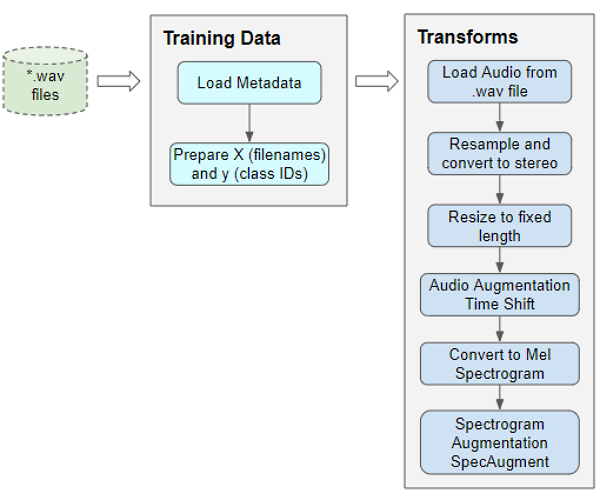

`def open()`
- The first thing we need is to read and load the audio file in “.wav” format. 
- Since we are using Pytorch for this example, the implementation below uses torchaudio for the audio processing, but librosa will work just as well.

`def rechannel()`
- Some of the sound files are mono (ie. 1 audio channel) while most of them are stereo (ie. 2 audio channels). 
- Since our model expects all items to have the same dimensions, we will convert the mono files to stereo, by duplicating the first channel to the second.

`def pad_trunc()`
- We then resize all the audio samples to have the same length by either extending its duration by padding it with silence, or by truncating it. 
- We add that method to our AudioUtil class.

`def time_shift()`
- Next, we can do data augmentation on the raw audio signal by applying a Time Shift to shift the audio to the left or the right by a random amount. 

`def spectro_gram()`
- We then convert the augmented audio to a Mel Spectrogram. 
- They capture the essential features of the audio and are often the most suitable way to input audio data into deep learning models.

`def spectro_augment()`
  
- Now we can do another round of augmentation, this time on the Mel Spectrogram rather than on the raw audio. We will use a technique called SpecAugment that uses these two methods:
    - **Frequency mask** — randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.
    - **Time mask** — similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars. 


In [ ]:
class AudioUtil():
    """
    Load an audio file. 

    Return
    ------
    The signal as a tensor and the sample rate
    """
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    # Convert the given audio to the desired number of channels
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return ((resig, sr))

    # Since Resample applies to a single channel,
    # we resample one channel at a time
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1, :])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:, :])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:, :max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # Generate a Spectrogram
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(
            sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    """
    Augment the Spectrogram by masking out some sections of it in both the frequency
    dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    overfitting and to help the model generalise better. The masked sections are
    replaced with the mean value. 
    """
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(
                freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(
                time_mask_param)(aug_spec, mask_value)

        return aug_spec

# Custom Data Loader
<hr style = "border:2px solid black" ></hr>


- To feed your data to a model with Pytorch, we need two objects:

    - A custom Dataset object that uses all the audio transforms to pre-process an audio file and prepares one data item at a time.
    - A built-in DataLoader object that uses the Dataset object to fetch individual data items and packages them into a batch of data.
    


In [ ]:
# Sound Dataset
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
    
    # Number of items in dataset    
    def __len__(self):
        return len(self.df)
    
    # Get i'th item in dataset    
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + self.df.loc[idx, 'relative_path']
        # Get the Class ID
        class_id = self.df.loc[idx, 'classID']

        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(
            shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(
            sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id


- The recommendation of the dataset creators is to use the folds for doing 10-fold cross-validation to report metrics and evaluate the performance of your model. 

- However, since our goal in this article is primarily as a demo of an audio deep learning example rather than to obtain the best metrics, we will ignore the folds and treat all the samples simply as one large data.

- We use our custom Dataset to load the Features and Labels from our Pandas dataframe and split that data randomly in an 80:20 ratio into training and validation sets. We then use them to create our training and validation Data Loaders.
    


In [ ]:
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

# Modelling
<hr style = "border:2px solid black" ></hr>



- Since our data now consists of Spectrogram images, we build a CNN classification architecture to process them. It has four convolutional blocks which generate the feature maps. 
- That data is then reshaped into the format we need so it can be input into the linear classifier layer, which finally outputs the predictions for the 10 classes.
- More info on the model are as follows:
    - A batch of images is input to the model with shape (batch_sz, num_channels, Mel freq_bands, time_steps) ie. (16, 2, 64, 344).
    - Each CNN layer applies its filters to step up the image depth ie. number of channels. The image width and height are reduced as the kernels and strides are applied. Finally, after passing through the four CNN layers, we get the output feature maps ie. (16, 64, 4, 22).
    - This gets pooled and flattened to a shape of (16, 64) and then input to the Linear layer.
    - The Linear layer outputs one prediction score per class ie. (16, 10)



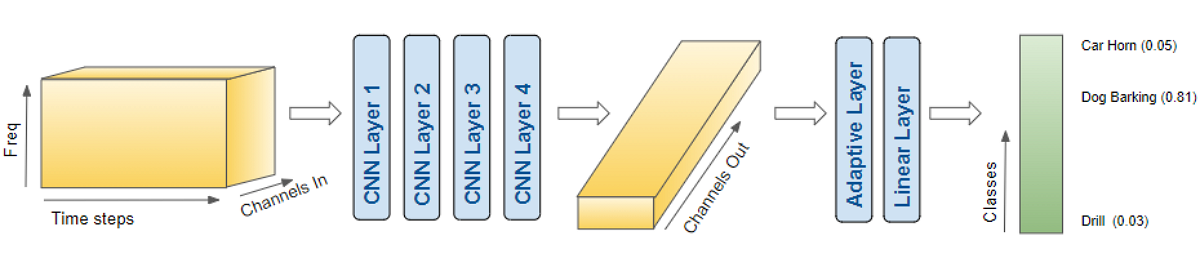

In [ ]:
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(
            5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(
            3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(
            3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(
            3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [ ]:
# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

# Training
<hr style = "border:2px solid black" ></hr>

In [ ]:
def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(
                                                        len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            # if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')

In [ ]:
num_epochs = 2   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

# Inference
<hr style = "border:2px solid black" ></hr>


- Ordinarily, as part of the training loop, we would also evaluate our metrics on the validation data. We would then do inference on unseen data, perhaps by keeping aside a test dataset from the original data. However, for the purposes of this demo, we will use the validation data for this purpose.

- We run an inference loop taking care to disable the gradient updates. The forward pass is executed with the model to get predictions, but we do not need to backpropagate or run the optimizer.
    


In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference(model, val_dl):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')


# Run inference on trained model with the validation set
inference(myModel, val_dl)

# References
<hr style = "border:2px solid black" ></hr>


- https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
- [Sound 8K dataset](https://urbansounddataset.weebly.com/urbansound8k.html)
- [Data augmentation for audio](https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52)

